<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/socially_distanced_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Political orientation of blogs

*clustering*, *spectral clustering*

**Problem**

We will use a political blogs dataset, first compiled for the paper Lada A. Adamic and Natalie Glance, "The political blogosphere and the 2004 US Election", in Proceedings of the WWW-2005 Workshop on the Weblogging Ecosystem (2005), to identify political orientation of these blogs. The data provided are:
* `edges.txt` The dataset has two columns, which represent the edges between the vertices.
* `nodes.txt` The dataset has four columns. Represents a graph with $n=1490$ nodes or blogs. The first column has a 0-1 label which correspond to the true political orientation of the blog.

**Method**

We treat the network as an undirectly graph. Then perform spectral clustering on the graph.

Assume the number of clusters is $k$. Here we are trying to classify blogs into groups of similar kind. However, the definition of similar can be tricky here. Can we interpret similarity as similar content or viewpoints or political standing?  Assume that two blogs are connected if one cited the other, one blog may cite another blog to support its own view points or to debate against it. So we cannot say that our algorithm would classify blogs into groups of similar viewpoints. Conservatively speaking, we can interpret the blog communities as blogs that share similar topics.

## Implementation

The implementation is found in `blog_classification.py`. The function `logClustering(k, spectralType)` takes in two parameters, where $k$ is the number of clusters. The default setting is to use regular spectral clustering. If the user specifies `spectralType = "variant"`, then the variant of spectral clustering is used. The function outputs an array object `cluster` of size $k$ x $3$ which contains the following cluster level information: political label, number of nodes, number of mismatched nodes, mismatch rate. \\

An overview of the spectral clustering algorithm implementation is the following:
1. We read in the `edges.txt` and constructed an adjacency matrix $A$ of size 1490 x 1490
2. We removed isolated nodes from A, obtaining a new A of 1224 x 1224. Every node in this new matrix is connected to at least one other node
3. The degree matrix D is computed. Then we obtain the Laplacian graph $L = D - A$
4. We performed eigendecomposition on L and find its eigenvectors and eigenvalues
5. The $k$ smallest eigenvectors were selected and their respective eigenvectors were used to obtain a new feature matrix 
6. We run k-means on the feature matrix, treating each feature vector as a data point
7. We read in the `nodes.txt` to get the individual labels and calculate the cluster label using majority vote. Then we calculate the mismatch rate for the clsuter. The overall mismatch rate for all clusters is (weighted mismatch rate of clusters):

$$
mismatch-rate = \frac{\sum^k_{j=1} number-of-mismatched-nodes-in-cluster-j}{total-number-of-nodes}
$$



In [8]:
import os
import numpy as np
from os.path import abspath, exists
from scipy import sparse
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import collections

In [15]:
def import_labels():
    # the data has 1490 nodes, first column is the ID, third column is their label
    f_path = abspath("data/nodes.txt")
    idx2label = []
    if exists(f_path):
        with open(f_path) as fid:
            for line in fid.readlines():
                label = int(line.split("\t", 4)[2])  # tab delimiter, 4 cols
                idx2label.append(label)
    return idx2label


def import_graph():
    # the data has 19090 edges, with duplicates
    f_path = abspath("data/edges.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            lines = [line.split() for line in graph_file]
    return np.array(lines).astype(int)

In [27]:
# Function to run blog clustering
# @k is the number of clusters
# @spectralType == "variant" implements the variant, otherwise is regular spectral clustering
def blogClustering(k, spectralType):  

    # load the graph
    edges = import_graph()    # 19090 x 2
    labels = import_labels()  # 1490 x 1

    n = len(labels)          # number of nodes
    i = edges[:, 0]-1        # get first column 
    j = edges[:, 1]-1        # get second column 
    v = np.ones((edges.shape[0], 1)).flatten()  

    ### Get Adjacency matrix
    # data is given as (team 1, team 2) (no dups)
    # A gives the edges from team 1 to team 2
    # A^T gives the edges from team 2 to team 1
    # note that in the data, there are duplicates, we want undirected, unweighted graph
    # so we avoid double counting by taking the max of the value and 1
    A = sparse.coo_matrix((v, (i, j)), shape=(n, n)) 
    A = (A + np.transpose(A))
    A = (A > 0).astype(np.int) 

    # remove isolated nodes
    rmidx = np.where(np.sum(A, axis=1) == 0)[0] 
    A = A.toarray()
    A = np.delete(A, rmidx, axis=1)
    A = np.delete(A, rmidx, axis=0)
    labels = np.delete(labels, rmidx)

    # Degree matrix and Laplacian graph
    if spectralType == "variant":
        D = np.diag(1/np.sqrt(np.sum(A, axis=1)))  # 321x321
        L = D @ A @ D   
    else:
        D = np.diag(np.sum(A, axis=1))
        L = D - A

    # Eigendecomposition 
    lam, vec = np.linalg.eig(L)
    if spectralType == "variant":
        idx = lam.argsort()[::-1][:k]       # k largest
    else:
        idx = lam.argsort()[:k]             # k smallest eigen values: 0, 0, 0.168691, 0.2995, 0.37576...
    vec = vec[:, idx].real  
    vec = vec/np.repeat(np.sqrt(np.sum(vec*vec, axis=1).reshape(-1, 1)), k, axis=1) # normalization

    # k-means
    kmeans = KMeans(n_clusters=k).fit(vec)
    assignments = kmeans.labels_
    # (optional) distirbution of assignments
    # unique, counts = np.unique(assignments, return_counts=True)
    # distr = np.asarray((unique, counts)).T
    # print(distr)
    # plt.hist(assignments, bins='auto')
    # plt.show()

    # cluster labels by majority vote:
    # cluster metadata: [cluster label, number of nodes, number of mismatches, mismatch rate]
    cluster = np.empty([k, 4])
    for i in range(k):
        idx = np.where(assignments == i)[0]
        n0 = np.where(labels[idx] == 0)[0]
        n1 = np.where(labels[idx] == 1)[0]
        cluster[i, 1] = len(idx)
        if len(n0) > len(n1):
            cluster[i, 0] = 0
            cluster[i, 2] = len(n1)
            cluster[i, 3] = len(n1) / len(idx)
        else:
            cluster[i, 0] = 1
            cluster[i, 2] = len(n0)
            cluster[i, 3] = len(n0) / len(idx)
    mismatch = np.sum(cluster[:, 2], axis = 0) / len(labels)  #  mismatch = # mismatch / total # nodes
    
    print("Mismatch rate for k = ", k, " is ", mismatch)
    return cluster, mismatch

In [17]:
# test
cluster, mismatch = blogClustering(2, "regular")
print(cluster)

Mismatch rate for k =  2  is  0.47875816993464054


\subsection{Results}

The cluster level results for $k=2,3,4$ are summarized below. We can observe that given a small $k$, most blogs are classified into one cluster. The overall mismatch rates are greater than $0.47$ in all three cases.

| Number of clusters | Cluster | Number of nodes | Majority label | Mismatch rate |
| --- | --- | --- | --- | --- |
| k=2 | 1   |1222 | 1 	| 0.4795 |
| k=2 | 2   | 2   | 0   | 0      | 
| k=3 | 1   | 1217 | 1 	| 0.4807 |
| k=3 | 2   |  5   | 1  | 0.2    |
| k=3 | 3   |  2   | 0  | 0      |
| k=4 | 1   | 1214 | 1 	| 0.4819 |
| k=4 | 2   |  5   | 1  | 0.2    |
| k=4 | 3   |  3   | 1  | 0      |
| k=4 | 4   |  2   | 0  | 0      |

We find the best $k$ as follows.

Mismatch rate for k =  2  is  0.47875816993464054
Mismatch rate for k =  3  is  0.47875816993464054
Mismatch rate for k =  4  is  0.47875816993464054
Mismatch rate for k =  5  is  0.477124183006536
Mismatch rate for k =  6  is  0.47549019607843135
Mismatch rate for k =  7  is  0.4722222222222222
Mismatch rate for k =  8  is  0.4722222222222222
Mismatch rate for k =  9  is  0.4681372549019608
Mismatch rate for k =  10  is  0.4583333333333333
Mismatch rate for k =  11  is  0.4542483660130719
Mismatch rate for k =  12  is  0.4485294117647059
Mismatch rate for k =  13  is  0.4444444444444444
Mismatch rate for k =  14  is  0.09313725490196079
Mismatch rate for k =  15  is  0.06045751633986928
Mismatch rate for k =  16  is  0.05718954248366013
Mismatch rate for k =  17  is  0.049019607843137254
Mismatch rate for k =  18  is  0.04656862745098039
Mismatch rate for k =  19  is  0.04820261437908497
Mismatch rate for k =  20  is  0.04493464052287582
Mismatch rate for k =  21  is  0.04330065359477

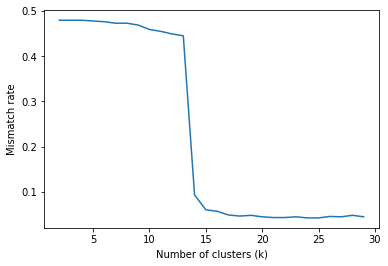

In [30]:
# tuning k 
maxk = 30
x_values, y_values = [], []
for i in range(2, maxk):
    cluster, mismatch = blogClustering(i, spectralType = "regular")
    y_values.append(mismatch)        
    x_values.append(i)
    
plt.plot(x_values, y_values)
plt.ylabel("Mismatch rate")
plt.xlabel('Number of clusters (k)')
plt.show()

It is interesting to observe that under small values of k, we were unable to find node communities that share
the same political view; for a large enough k, our blog classi cation is able to classify blogs of the same
political view into similar communities. So one take away is that the number of clusters is very important
and from which we may observe di erent insights.

Initially, we interpreted a community of blogs as blogs that share similar content or topics. When we
classify blogs into k=18 topics, we reveal that most blogs of the same topic share same political views.
This tells us that nowadays, political blogs are quite biased and selective of what they say. The authors of
the same political view would only select topics and perspectives that favor their views and not mention the
other side of the story.